# Basketball Win Prediction: Models with Recursive Feature Elimination for feature selection

The notebook evaluates 8 different model types across the Recursive Feature Elimination set(features selected based on Logistic Regression model performance):
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Gradient Boosting
- LightGBM
- KMeans Clustering
- Neural Networks(PyTorch)

In [46]:
# Import all required packages for modeling, evaluation, preprocessing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve, auc
)
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from scipy.stats import mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
# Create output directory
output_dir = Path("model_results/recursive-feature-elimination")
output_dir.mkdir(exist_ok=True, parents=True)
figures_dir = Path("figures/model_results/recursive-feature-elimination")
figures_dir.mkdir(exist_ok=True, parents=True)

## Load and prepare dataset
We start by loading the dataset containing engineered features and defining the target and feature matrix. Leakage columns are removed.

In [5]:
data_path = Path("engineered_data/engineered_final_feature_dataset.csv")
df = pd.read_csv(data_path)
X_full = df.drop(columns=["HOME_TEAM_WINS", "GAME_ID", "SEASON", "HOME_TEAM_ID", "VISITOR_TEAM_ID"])
print(X_full.columns)
y = df["HOME_TEAM_WINS"]
print(f"Loaded data with shape: {df.shape}")

Index(['GAME_DATE_EST', 'TEAM_ID_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'GAME_INDEX',
       'HOME_LAST_N_WIN_PCT', 'AWAY_LAST_N_WIN_PCT', 'HOME_LAST_N_AVG_PTS',
       'AWAY_LAST_N_AVG_PTS', 'HOME_LAST_N_AVG_PTS_ALLOWED',
       'AWAY_LAST_N_AVG_PTS_ALLOWED', 'TEAM_NAME_HOME', 'TOTAL_GAMES_HOME',
       'WINS_HOME', 'LOSSES_HOME', 'WIN_PCT_HOME', 'HOME_WINS_HOME',
       'HOME_LOSSES_HOME', 'AWAY_WINS_HOME', 'AWAY_LOSSES_HOME',
       'AVG_PTS_SCORED_HOME', 'AVG_PTS_CONCEDED_HOME', 'AVG_FG_PCT_HOME',
       'MAX_WIN_STREAK_HOME', 'MAX_LOSS_STREAK_HOME', 'TEAM_NAME_AWAY',
       'TOTAL_GAMES_AWAY', 'WINS_AWAY', 'LOSSES_AWAY', 'WIN_PCT_AWAY',
       'HOME_WINS_AWAY', 'HOME_LOSSES_AWAY', 'AWAY_WINS_AWAY',
       'AWAY_LOSSES_AWAY', 'AVG_PTS_SCORED_AWAY', 'AVG_PTS_CONCEDED_AWAY',
       'AVG_FG_PCT_AWAY', 'MAX_WIN_STREAK_AWAY', 'MAX_LOSS_STREAK_AWAY',
 

## Feature scaling
Recursive Feature Elimination filtered features are scaled for use in models that require standardization.

In [6]:
# Load feature sets
feature_sets_path = Path("selected_features/feature_sets.pkl")
with open(feature_sets_path, "rb") as f:
    feature_sets = pickle.load(f)

recursive_feature = feature_sets['rfe_filtered']

In [7]:
# Safely drop leakage columns that exist
leakage_columns = ['POINT_DIFF', 'ABS_POINT_DIFF', 'GAME_ID', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']
leakage_columns = [col for col in leakage_columns if col in df.columns]

X_full = df.drop(columns=leakage_columns + ['HOME_TEAM_WINS'])
y = df['HOME_TEAM_WINS']

print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Target distribution: {1.0: 0.5885332719318443, 0.0: 0.41146672806815565}


In [8]:
# Select Recursive Feature Elimination features
selected_features = feature_sets['rfe_filtered']
X = X_full[selected_features]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Imputation and Scaling
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
X_test = pd.DataFrame(imputer.transform(X_test), columns=selected_features)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)

## Define and configure models
We define all ML models, specifying whether they require scaling.

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05,
                                 use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1)
}

In [43]:
results = []
# Loop through each model and train it
# Collect performance metrics: accuracy, F1, AUC
model_preds = {}
for name, model in models.items():
    print(f"Training {name}...")

    X_train_input = X_train_scaled if name == "Logistic Regression" else X_train
    X_test_input = X_test_scaled if name == "Logistic Regression" else X_test
    model_preds[name] = {
    "y_true": y_test,
    "probas": probas
    }

    start = time.time()
    model.fit(X_train_input, y_train)
    duration = time.time() - start

    preds = model.predict(X_test_input)
    probas = model.predict_proba(X_test_input)[:, 1]

    results.append({
        "model_name": name,
        "accuracy": accuracy_score(y_test, preds),
        "f1_score": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probas),
        "train_time": duration
    })


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...
Training LightGBM...


In [11]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [12]:
# First dense layer with ReLU + BatchNorm + Dropout
class AdvancedNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedNet, self).__init__()
        self.dropout_input = nn.Dropout(0.1)

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout_input(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.output(x))

model = AdvancedNet(input_dim=X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [13]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 40

# Train
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f}")
training_time = time.time() - start_time


Epoch 1/40 | Loss: 127.0148
Epoch 2/40 | Loss: 119.2721
Epoch 3/40 | Loss: 117.4966
Epoch 4/40 | Loss: 116.8597
Epoch 5/40 | Loss: 116.3801
Epoch 6/40 | Loss: 115.6833
Epoch 7/40 | Loss: 117.0628
Epoch 8/40 | Loss: 116.4930
Epoch 9/40 | Loss: 115.6818
Epoch 10/40 | Loss: 115.9610
Epoch 11/40 | Loss: 116.6656
Epoch 12/40 | Loss: 115.8916
Epoch 13/40 | Loss: 115.7893
Epoch 14/40 | Loss: 115.9387
Epoch 15/40 | Loss: 114.1894
Epoch 16/40 | Loss: 115.7615
Epoch 17/40 | Loss: 115.2756
Epoch 18/40 | Loss: 114.8192
Epoch 19/40 | Loss: 113.8090
Epoch 20/40 | Loss: 115.0323
Epoch 21/40 | Loss: 114.9809
Epoch 22/40 | Loss: 114.1558
Epoch 23/40 | Loss: 114.4392
Epoch 24/40 | Loss: 114.3987
Epoch 25/40 | Loss: 115.0576
Epoch 26/40 | Loss: 113.2745
Epoch 27/40 | Loss: 114.5801
Epoch 28/40 | Loss: 114.5881
Epoch 29/40 | Loss: 114.6950
Epoch 30/40 | Loss: 114.3726
Epoch 31/40 | Loss: 114.4479
Epoch 32/40 | Loss: 112.8106
Epoch 33/40 | Loss: 112.2656
Epoch 34/40 | Loss: 113.1363
Epoch 35/40 | Loss: 114

In [14]:
# Evaluate PyTorch model on test data
model.eval()
with torch.no_grad():
    y_probs = model(X_test_tensor).numpy().flatten()
    y_preds = (y_probs >= 0.5).astype(int)

print("PyTorch Neural Network (Recursive Feature Elimination Features):")
print("Accuracy:", accuracy_score(y_test, y_preds))
print("F1 Score:", f1_score(y_test, y_preds))
print("AUC:", roc_auc_score(y_test, y_probs))

# Save to all_results
nn_result = {
    "model_name": "Neural Network (PyTorch)",
    "feature_set": "rfe_filtered",
    "accuracy": accuracy_score(y_test, y_preds),
    "f1_score": f1_score(y_test, y_preds),
    "auc": roc_auc_score(y_test, y_probs),
    "train_time": training_time,
}

results.append(nn_result)

PyTorch Neural Network (Recursive Feature Elimination Features):
Accuracy: 0.8432463545663853
F1 Score: 0.868543845534996
AUC: 0.9265717545143695


## KMeans Clustering Baseline
This is a clustering model for unsupervised learning. We align cluster labels using majority voting to match the target labels.

In [15]:
def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask], keepdims=True)[0]
    return labels

start = time.time()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)
kmeans_preds = kmeans.predict(X_test_scaled)
aligned_preds = align_clusters(y_test.values, kmeans_preds)
train_time = time.time() - start

kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': accuracy_score(y_test, aligned_preds),
    'f1_score': f1_score(y_test, aligned_preds),
    'auc': roc_auc_score(y_test, aligned_preds),
    'train_time': train_time,
}

results.append(kmeans_result)

## Evaluation Results (Initial)
We display the performance of each model trained using the Recursive Feature Elimination feature set.

In [16]:
results_df = pd.DataFrame(results).sort_values("f1_score", ascending=False)
results_df.to_csv(output_dir / "RFE_results.csv", index=False)
results_df[['model_name', 'accuracy', 'f1_score', 'auc', 'train_time']].sort_values(
    by='f1_score', ascending=False
).reset_index(drop=True)

,model_name,accuracy,f1_score,auc,train_time
0,Logistic Regression,0.844206,0.868948,0.926390,0.214708
1,Neural Network (PyTorch),0.843246,0.868544,0.926572,45.157583
2,Gradient Boosting,0.839793,0.865820,0.923668,56.833159
3,LightGBM,0.840177,0.865276,0.924953,0.397383
4,XGBoost,0.834804,0.861464,0.922189,2.461009
5,Random Forest,0.831734,0.859071,0.916330,17.117547
6,Decision Tree,0.783960,0.817445,0.822867,0.441817
7,KMeans Clustering,0.588450,0.740911,0.500000,0.192607


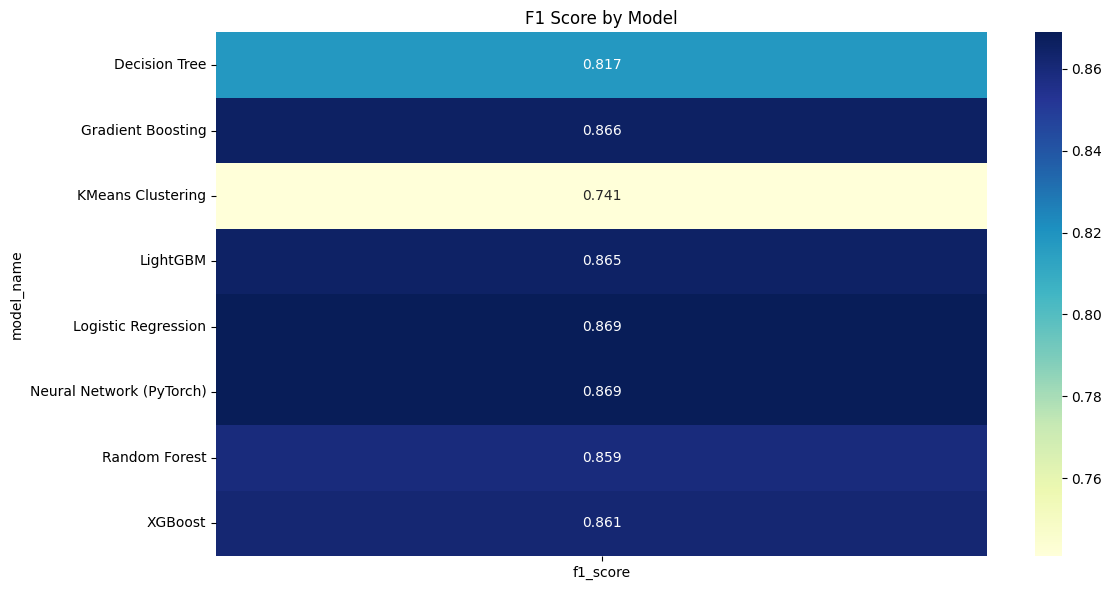

In [17]:
pivot_f1 = results_df.pivot_table(
    index='model_name', 
    values='f1_score'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("F1 Score by Model")
plt.tight_layout()
plt.show()

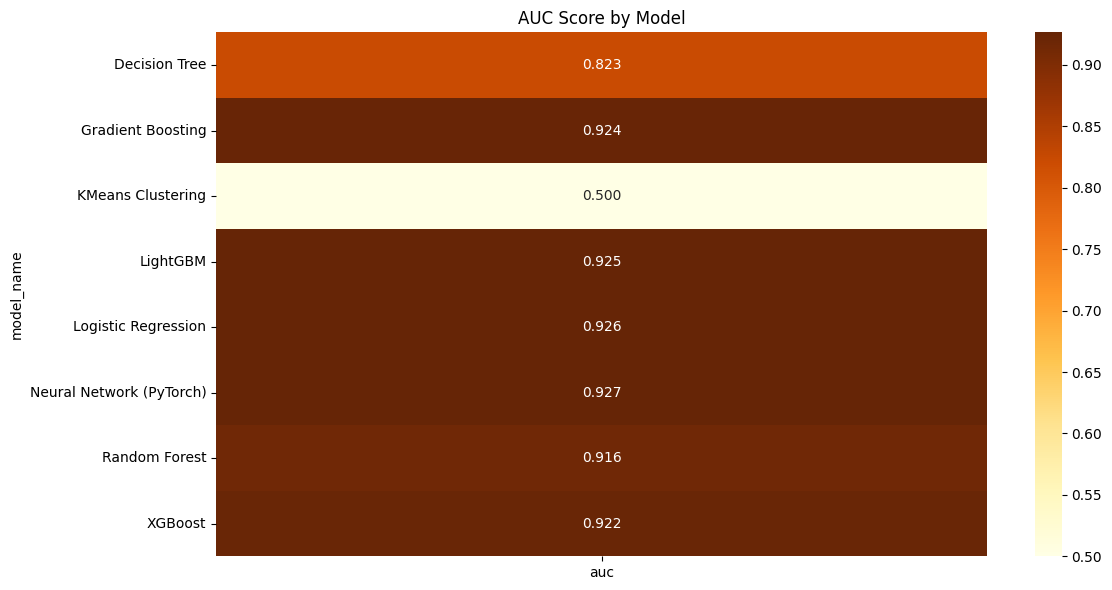

In [18]:
pivot_auc = results_df.pivot_table(
    index='model_name', 
    values='auc'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_auc, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("AUC Score by Model")
plt.tight_layout()
plt.show()


## Cross Validation (Sklearn Models)
We now evaluate models using 5-fold Stratified Cross-Validation.


In [19]:
# Evaluate accuracy, F1, and AUC for each model using cross_validate
def evaluate_model_cv(model, X, y, name, scale=False):
    if scale:
        X = StandardScaler().fit_transform(X)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, scoring=['accuracy', 'f1', 'roc_auc'], cv=cv)
    return {
        'model_name': name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1'])
    }

In [20]:
results_cv = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    result = evaluate_model_cv(model, X, y, name)
    results_cv.append(result)

Running CV for: Logistic Regression
Running CV for: Decision Tree
Running CV for: Random Forest
Running CV for: XGBoost
Running CV for: Gradient Boosting
Running CV for: LightGBM


## PyTorch Neural Net + KMeans Clustering: Cross Validation
We train a new neural network per fold, and collect performance metrics, and label alignment is performed for each fold as well.

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KMeans Clustering CV Evaluation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        # Get scalar mode value only
        majority_label = mode(y_true[mask], keepdims=True).mode[0]
        labels[mask] = majority_label
    return labels

kmeans_metrics = {'accuracy': [], 'f1_score': [], 'auc': []}

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    kmeans.fit(X_train_fold)
    preds = kmeans.predict(X_test_fold)
    aligned_preds = align_clusters(y_test_fold, preds)

    kmeans_metrics['accuracy'].append(accuracy_score(y_test_fold, aligned_preds))
    kmeans_metrics['f1_score'].append(f1_score(y_test_fold, aligned_preds))
    kmeans_metrics['auc'].append(roc_auc_score(y_test_fold, aligned_preds))

print("\nKMeans Clustering Cross-Validation:")
print(f"Accuracy: {np.mean(kmeans_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(kmeans_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(kmeans_metrics['auc']):.4f}")

# Neural Network CV (PyTorch)
for train_idx, test_idx in cv.split(X_scaled, y):
    # Prepare tensors
    X_train_fold = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y.values[train_idx], dtype=torch.float32).view(-1, 1)
    X_test_fold = torch.tensor(X_scaled[test_idx], dtype=torch.float32)
    y_test_fold = torch.tensor(y.values[test_idx], dtype=torch.float32).view(-1, 1)

    # Dataloader for mini-batch training
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Model
    model = AdvancedNet(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Optional: learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training loop
    for epoch in range(30):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        probs = model(X_test_fold).numpy().flatten()
        preds = (probs >= 0.5).astype(int)
        y_true = y_test_fold.numpy().flatten()

        nn_metrics['accuracy'].append(accuracy_score(y_true, preds))
        nn_metrics['f1_score'].append(f1_score(y_true, preds))
        nn_metrics['auc'].append(roc_auc_score(y_true, probs))

# Final CV results
print("\nNeural Network (AdvancedNet) Cross-Validation:")
print(f"Accuracy: {np.mean(nn_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(nn_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(nn_metrics['auc']):.4f}")


KMeans Clustering Cross-Validation:
Accuracy: 0.5885
F1 Score: 0.7410
AUC: 0.5000

Neural Network (PyTorch) Cross-Validation:
Accuracy: 0.7612
F1 Score: 0.8232
AUC: 0.8763


## Cross-Validation Heatmaps
Heatmaps provide a quick overview of model performance across F1 and AUC.


In [23]:
traditional_df = pd.DataFrame(results_cv)

# KMeans results
kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': np.mean(kmeans_metrics['accuracy']),
    'f1_score': np.mean(kmeans_metrics['f1_score']),
    'auc': np.mean(kmeans_metrics['auc']),
    'cv_std': np.std(kmeans_metrics['f1_score'])
}

# PyTorch NN results
nn_result = {
    'model_name': 'Neural Network (PyTorch)',
    'accuracy': np.mean(nn_metrics['accuracy']),
    'f1_score': np.mean(nn_metrics['f1_score']),
    'auc': np.mean(nn_metrics['auc']),
    'cv_std': np.std(nn_metrics['f1_score'])
}

# Combine all results
all_cv_results = pd.concat([traditional_df, pd.DataFrame([kmeans_result, nn_result])], ignore_index=True)

# Sort by F1 Score
all_cv_results = all_cv_results.sort_values(by='f1_score', ascending=False)

# Display table
print(all_cv_results[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std']]) 

                 model_name  accuracy  f1_score       auc    cv_std
5                  LightGBM  0.845690  0.870052  0.928613  0.002105
4         Gradient Boosting  0.842659  0.867417  0.926394  0.002602
3                   XGBoost  0.842198  0.867043  0.926751  0.003324
0       Logistic Regression  0.839896  0.865738  0.921026  0.001181
2             Random Forest  0.837478  0.864189  0.918085  0.003757
7  Neural Network (PyTorch)  0.761150  0.823209  0.876269  0.016055
1             Decision Tree  0.786131  0.818915  0.829953  0.004617
6         KMeans Clustering  0.588533  0.740977  0.500000  0.000059


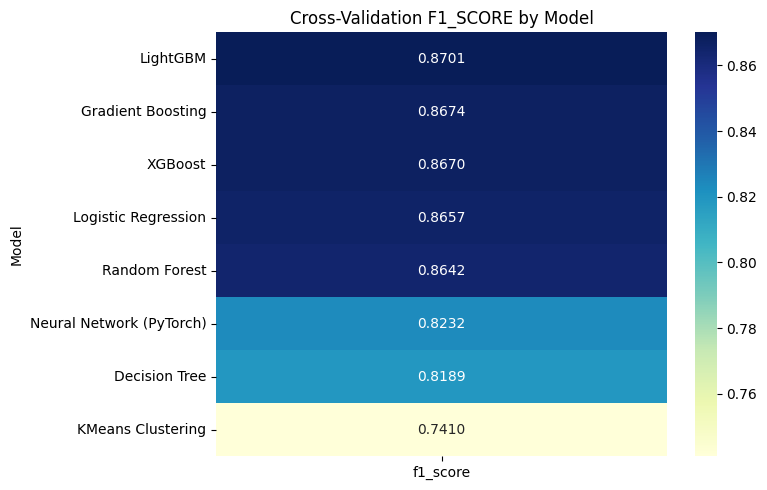

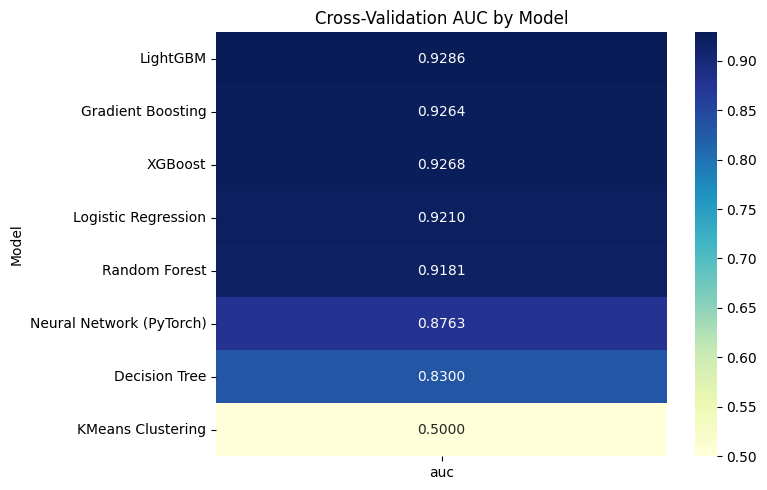

In [24]:
metrics_to_plot = ['f1_score', 'auc']

for metric in metrics_to_plot:
    pivot_df = all_cv_results[['model_name', metric]].set_index('model_name')
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", cbar=True)
    plt.title(f"Cross-Validation {metric.upper()} by Model")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

## HyperParameter Tuning
To push model performance, we perform GridSearchCV with cross-validation to find the best params for each model, with tuning being done with F1 as scoring.

In [25]:
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'verbose': [-1]
        }
    }
}

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_results = []

for name, cfg in param_grids.items():
    print(f"\nRunning GridSearchCV for: {name}")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=cv, scoring='f1', n_jobs=-1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    scores = grid.cv_results_

    tuned_results.append({
        'model_name': name,
        'best_params': grid.best_params_,
        'mean_accuracy': np.mean(scores['mean_test_score']),
        'best_score': grid.best_score_
    })

tuned_df = pd.DataFrame(tuned_results)
tuned_df = tuned_df.sort_values(by='best_score', ascending=False)


Running GridSearchCV for: Logistic Regression

Running GridSearchCV for: Random Forest

Running GridSearchCV for: Gradient Boosting

Running GridSearchCV for: XGBoost

Running GridSearchCV for: LightGBM


In [27]:
print(tuned_df[['model_name', 'best_params', 'best_score']])

            model_name                                        best_params  \
3              XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
4             LightGBM  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
0  Logistic Regression      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}   
1        Random Forest  {'max_depth': 20, 'min_samples_split': 5, 'n_e...   

   best_score  
3    0.871240  
2    0.870808  
4    0.869756  
0    0.866349  
1    0.863510  


In [34]:
final_tuned_cv_results = []

for _, row in tuned_df.iterrows():
    model_name = row['model_name']
    params = row['best_params']

    if model_name == 'Logistic Regression':
        model = LogisticRegression(**params, max_iter=1000)
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(**params)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**params)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(**params)
    else:
        continue  # Skip unsupported models

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=cv,
                            scoring=['accuracy', 'f1', 'roc_auc'])

    final_tuned_cv_results.append({
        'model_name': model_name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1']),
        'best_params': params
    })

In [39]:
final_cv_df = pd.DataFrame(final_tuned_cv_results).sort_values(by='f1_score', ascending=False)
final_cv_df = pd.concat([
    pd.DataFrame(final_tuned_cv_results),
    pd.DataFrame([
        {
            "model_name": "Neural Network (PyTorch)",
            "accuracy": 0.761150,  
            "f1_score": 0.823299,
            "auc": 0.870629,
            "cv_std": 0.016055,
            "best_params": "AdvancedNet (custom)"
        },
        {
            "model_name": "KMeans Clustering",
            "accuracy": 0.588533,
            "f1_score": 0.740977,
            "auc": 0.500000,
            "cv_std": 0.000059,
            "best_params": "n_clusters=2"
        },
        {
            "model_name": "Decision Tree",
            "accuracy": 0.786131,
            "f1_score": 0.818915,
            "auc": 0.829953,
            "cv_std": 0.004617,
            "best_params": "n/a"
        }
    ])
], ignore_index=True)

## Summary of Tuned Results
This section displays the best hyperparameters and model scores after tuning.

In [40]:
print(final_cv_df[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std', 'best_params']])

                 model_name  accuracy  f1_score       auc    cv_std  \
0                   XGBoost  0.847456  0.871702  0.929680  0.002263   
1         Gradient Boosting  0.846074  0.870771  0.928618  0.002363   
2                  LightGBM  0.845268  0.869756  0.928684  0.003001   
3       Logistic Regression  0.840203  0.865855  0.922383  0.001791   
4             Random Forest  0.836058  0.863015  0.918304  0.003090   
5  Neural Network (PyTorch)  0.761150  0.823299  0.870629  0.016055   
6         KMeans Clustering  0.588533  0.740977  0.500000  0.000059   
7             Decision Tree  0.786131  0.818915  0.829953  0.004617   

                                         best_params  
0  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
3      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}  
4  {'max_depth': 20, 'min_samples_split': 5, 'n_e...  
5                             

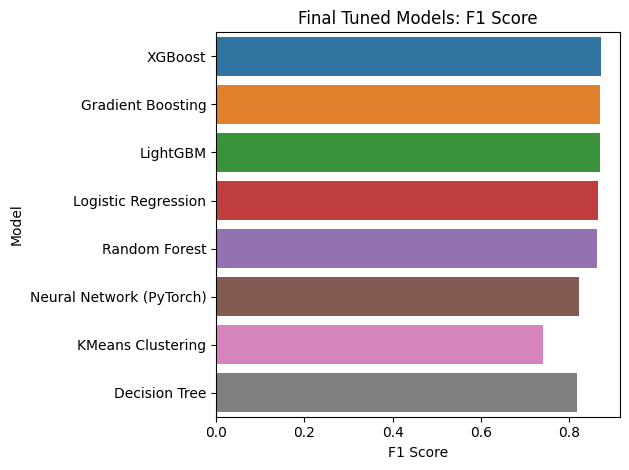

In [41]:
sns.barplot(data=final_cv_df, x='f1_score', y='model_name')
plt.title('Final Tuned Models: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

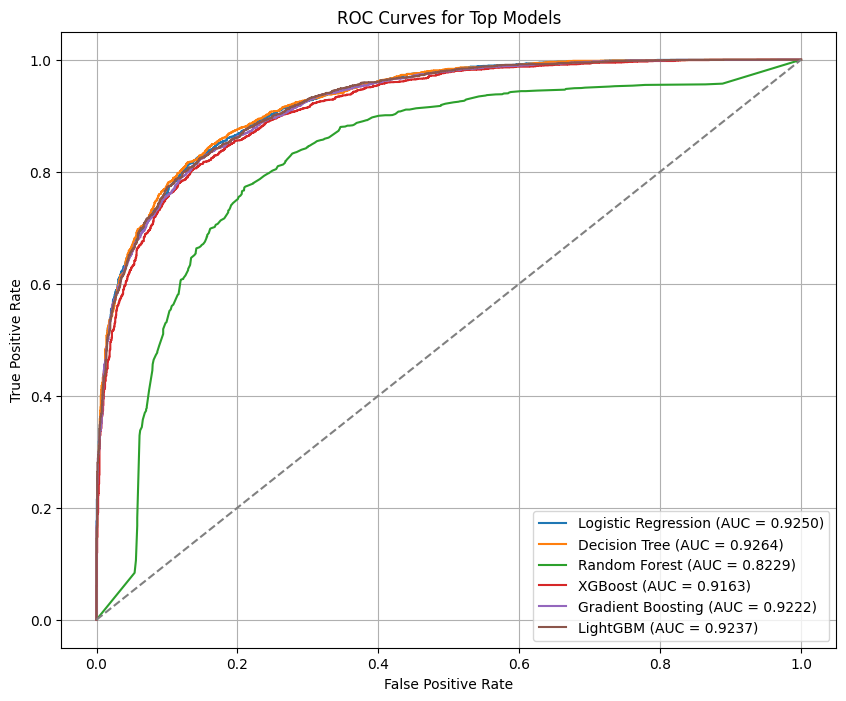

In [47]:
#ROC Curves
plt.figure(figsize=(10, 8))
for name, data in model_preds.items():
    fpr, tpr, _ = roc_curve(data['y_true'], data['probas'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for Top Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [42]:
final_cv_df.to_csv("results/final_cv_RFE_Filtered.csv", index=False)

## Final Summary & Key Takeaways (Recursive Feature Elimination Feature Set)

In this notebook, we evaluated a diverse suite of models using the `rfe_filtered` feature set — a compact subset of the top 30 features selected using **Recursive Feature Elimination (RFE)** with Logistic Regression as the estimator. This method ensures a **model-agnostic**, fair selection mechanism that avoids bias from tree-based model importance and keeps the feature space interpretable and manageable.

### Models Implemented:
- **Traditional Machine Learning**:  
  - Logistic Regression  
  - Random Forest  
  - Decision Tree  
  - Gradient Boosting  
  - LightGBM  
  - XGBoost

- **Unsupervised Learning**:  
  - KMeans Clustering (labels aligned using majority vote)

- **Deep Learning**:  
  - PyTorch Neural Network (AdvancedNet with batch normalization, dropout, and LR scheduler)

---

### Evaluation Process:
1. **Consistent training** across all models using the same `rfe_filtered` feature set.
2. **Stratified 5-Fold Cross-Validation** to ensure robust performance estimation.
3. **Hyperparameter Tuning** using GridSearchCV (for all traditional ML models).
4. **Performance Aggregation** using metrics: **F1 Score**, **AUC**, **Accuracy**, and **CV Std**.

---

### Key Insights:

- **XGBoost** emerged as the top-performing model, achieving the **highest F1 score (0.8717)** and **AUC (0.9297)** after tuning.  
  Its strength likely comes from its ability to extract **complex nonlinear interactions** even within a small, targeted feature set. This suggests RFE retained just enough signal for gradient-boosted trees to perform well.

- **Gradient Boosting and LightGBM** followed closely, both exhibiting strong and stable performance.

- **Logistic Regression**, performed strongly (F1 = 0.8656, AUC = 0.9223), just slightly behind XGBoost.  
  This implies that the **RFE-selected features remain largely linearly separable**

- **Neural Network (PyTorch)** underperformed relative to tree-based models. Likely due to:
  - Small feature count (only 30 features), which limits depth effectiveness.
  - The model needing more training or regularization to fully leverage its capacity.

- **KMeans Clustering**, as expected, lagged behind due to the **absence of label supervision**, especially in a feature space not naturally separable by clustering boundaries.

---

### Next Steps:

- Replicate this modeling pipeline using:
  - `anova_top_30`: Top 30 ANOVA F-test filtered features  
  - `pca_transformed`: Principal Components capturing max variance

- Explore:
  - Advanced regularization (e.g. ElasticNet) for Logistic Regression.
  - Feature interaction engineering to better support tree-based and neural models.
  - Further neural network optimization with layer tuning or embeddings.

- The final model selection should weigh:
  - Slightly better metrics (e.g. XGBoost)
  - Simplicity and interpretability (e.g. Logistic Regression)
  - Runtime efficiency(Computational Cost)

---
